<a href="https://colab.research.google.com/github/Lucs1590/AgiDataTest/blob/main/financial_inclusion_africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Inclusion in Africa
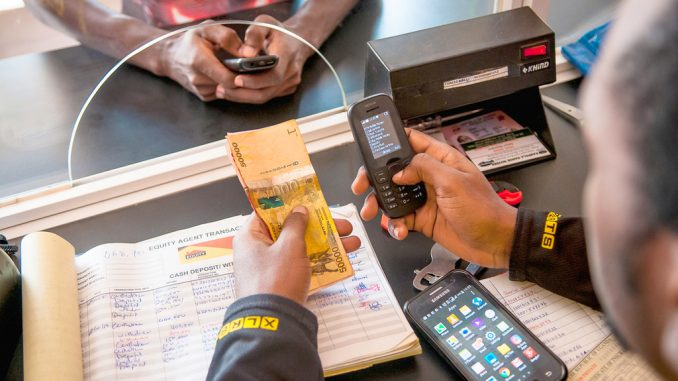

# Summary
* [Introduction](#intro)
* [Lib. Import](#imports)
* [Dataset Exploration](#dataset)
  * [Notebook Configuration](#settings)
  * [Dataset First Contact](#data-first)
  * [Pre-treatment](#pretreat)
  * [Analysis](#analysis)
    * [Initial Analysis](#init-analysis)
    * [Bank Access Analysis](#analysis-dist)
    * [Other Analytsis](#other-analysis)
* [Model](#model)
* [Evaluation](#evaluation)
* [Conclusion](#conclusion)
* [References](#references)

# Introduction <a name="intro"></a>
Among the great problems in Africa, one that impacts both the **human development** and the **economic** field is that of access to banks (for personal or commercial use), so that in a composite population of around 172,19 million people (The World Bank Group, 2020) in 4 countries, only 14% of the adult population, represented by 9,1 million, have this access (Zindi).

The fact is that this problem is aggravated when the indicator of access to banks **becomes the basis for measuring the financial inclusion indicator**, which can bring several benefits to those who have this access, such as the possibility of credit, financing and the like.

Thus, the present notebook proposes to create a model to predict which individuals are more likely to have or use a bank account.


---



# Libraries Import <a name="imports"></a>
First, I'll import all the requirement libraries to work with machine learning, image plotting, dataframes and more.

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning and math
import math
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats

# environment and settings
import glob
import zipfile
import gdown
import os
from os import path
# ----------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Data Exploration <a name="dataset"></a>
The dataset used for the study is composed of 4 countries - Kenya, Rwanda, Tanzania and Unganda. The main content of the dataset is related to demographic information and financial services used by approximately 33,600 people in Africa. These data are the results of Finscope surveys from 2016 to 2018.

## Notebook Config. <a name="settings"></a>
Here we are going to perform some notebook settings. Since I want the dataset to be accessible to everyone who uses the notebook, I'm going to download it in the local environment.

In [2]:
def unzip_file(_file, destination):
    with zipfile.ZipFile(_file, 'r') as zip_ref:
        zip_ref.extractall(destination)
    os.remove(_file)

In [3]:
def get_dataset(output, destination, url):
  try:
    gdown.download(url, output, quiet=False)
    unzip_file(output, destination)
  except Exception as e:
    print(e)
    raise ConnectionError('you need to be connected to some internet network to download the database.')


In [4]:
def has_files(_path):
    files = glob.glob(path.join(_path, "*.csv")).copy()
    return True if len(files) else False

In [5]:
pd.options.display.max_colwidth = 220
_path = os.path.abspath(os.getcwd())

if not has_files(_path):
  get_dataset(_path+'/financial-inclusion-in-africa.zip', _path,'https://drive.google.com/uc?export=download&id=10hXbHanxLZvvFN819v2dgWwab0cSY3IT')

In [6]:
datframe_vars = pd.read_csv('{}/VariableDefinitions.csv'.format(_path))
train_dataframe = pd.read_csv('{}/Train.csv'.format(_path))

## Dataset First Contact <a name="data-first"></a>
The first contact with the notebook could be via `Variable Definitions.csv` in this case, as this file should contain all column definitions.

In [7]:
datframe_vars

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,"The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know"
9,marital_status,"The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know"


In [8]:
train_dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,23524.0,2016.975939,0.847371,2016.0,2016.0,2017.0,2018.0,2018.0
household_size,23524.0,3.797483,2.227613,1.0,2.0,3.0,5.0,21.0
age_of_respondent,23524.0,38.805220,16.520569,16.0,26.0,35.0,49.0,100.0


In [9]:
train_dataframe.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [10]:
train_dataframe.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

In [11]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [12]:
for col in train_dataframe.columns:
    print(col,train_dataframe[col].unique())
    print("\n")

country ['Kenya' 'Rwanda' 'Tanzania' 'Uganda']


year [2018 2016 2017]


uniqueid ['uniqueid_1' 'uniqueid_2' 'uniqueid_3' ... 'uniqueid_8757'
 'uniqueid_8758' 'uniqueid_8759']


bank_account ['Yes' 'No']


location_type ['Rural' 'Urban']


cellphone_access ['Yes' 'No']


household_size [ 3  5  8  7  1  6  4 10  2 11  9 12 16 15 13 14 21 18 17 20]


age_of_respondent [ 24  70  26  34  32  42  54  76  40  69  64  31  38  47  27  48  25  21
  18  22  58  55  62  29  35  45  67  19  80  66  50  33  28  51  16  17
  30  37  59  65  46  56  52  23  43  49  44  72  53  63  39  81  78  36
  20  60  95  71  57  85  68  41  61  75  86  73  93  74  88  90  77  84
  82  89  79  83  94  87  92  91  98  97  96  99 100]


gender_of_respondent ['Female' 'Male']


relationship_with_head ['Spouse' 'Head of Household' 'Other relative' 'Child' 'Parent'
 'Other non-relatives']


marital_status ['Married/Living together' 'Widowed' 'Single/Never Married'
 'Divorced/Seperated' 'Dont know']


education_level [

In [13]:
'Dataframe shape: {}'.format(train_dataframe.shape)

'Dataframe shape: (23524, 13)'

In [14]:
'Variables out of "Variable Definitions" file: {}'.format(list(filter(lambda x: x,[(x if x not in datframe_vars['Variable Definitions'].to_list() else False ) for x in train_dataframe.columns])))

'Variables out of "Variable Definitions" file: [\'bank_account\']'

In [15]:
print('Rows size: {}'.format(train_dataframe.shape[0]))
print('Complete row size: {}'.format(train_dataframe.dropna().shape[0]))
print('Does the dataset have incomplete values? {}'.format(train_dataframe.isnull().values.any()))
print('Null values: {}'.format(train_dataframe.isnull().sum().sum()))

Rows size: 23524
Complete row size: 23524
Does the dataset have incomplete values? False
Null values: 0


In the first contact with the dataset, it was possible to have some insights, among which we can mention:

- Contrary to what was expected, when we compared the dataframe columns with the `Variable Definitions.csv` file we found that a column was missing, which is the column that indicates whether people have a bank account or not;
- Some columns like `bank_account` and` cellphone_access` are actually `bool`, although the type shown is `object`;
- The gender field has only the responses `Male` and `Female`, so we can transform them into binary variables. And the same for location;
- The dataset covers people aged 16 to 100 years;
- There is a wide variety of people who live in a house in Brazil when compared to countries like Brazil, as it is a range from 1 to 21 people;
- As described above, the dataset includes data from 2016 to 2018;
- Finally, it can be seen that the dataset does not have incomplete data, so it will not be necessary to handle empty data.

# Pre-treatment <a name="pretreat"></a>
After having performed a brief analysis of the dataset, we can see that it is possible to contribute to the quality of the dataset with Boolean types, for example. That way, before generating more insight, we'll treat the data.

In [16]:
def yes_no_to_bool(df, col, conditional):
  df[col] = df[col] == conditional
  return df

In [17]:
def to_one_zero(df, col, conditional):
  df[col] = np.where(df[col] == conditional, 1, 0)
  return df

In [18]:
train_dataframe = yes_no_to_bool(train_dataframe, "bank_account", "Yes")
train_dataframe = yes_no_to_bool(train_dataframe, "cellphone_access", "Yes")
train_dataframe = to_one_zero(train_dataframe, "gender_of_respondent", "Male")
train_dataframe = to_one_zero(train_dataframe, "location_type", "Urban")

In [19]:
train_dataframe.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account                bool
location_type              int64
cellphone_access            bool
household_size             int64
age_of_respondent          int64
gender_of_respondent       int64
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

# Analysis <a name="analysis"></a>
The analysis is where the hypotheses and questions that can bring an even greater understanding of the data are found, being able to aggregate groups, visualizations, statistics and so on.

## Initial Analysis <a name="init-analysis"></a>
In an initial analysis I will divide the columns of the dataset into categorical, numerical, Boolean and continuous, in addition to raising some hypotheses of values that contribute to the objective of the study, for example, observing outliers in numerical fields, like `age_of_respondent` and `household_size`.

In [20]:
categorical_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtypes == 'O']
boolean_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtypes == 'bool']
not_cat_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtypes != 'O' and train_dataframe[col].dtypes != 'bool']

In [21]:
print('Booleans: {0}\nCategorical: {1}\nNumerical/Continuous:{2}'.format(boolean_cols, categorical_cols, not_cat_cols))

Booleans: ['bank_account', 'cellphone_access']
Categorical: ['country', 'uniqueid', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
Numerical/Continuous:['year', 'location_type', 'household_size', 'age_of_respondent', 'gender_of_respondent']


Text(0, 0.5, 'Age')

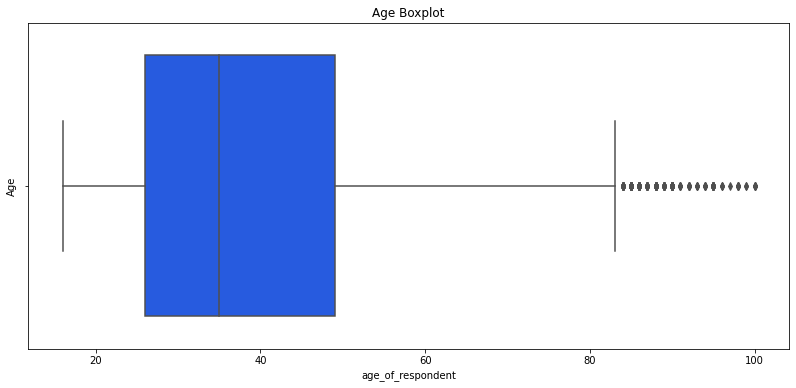

In [22]:
plt.figure(figsize=(30,6))
plt.subplot(1,2,1)
fig = sns.boxplot(x='age_of_respondent' ,data=train_dataframe ,orient='v', color='#084EFE')
fig.set_title("Age Boxplot")
fig.set_ylabel("Age")

Text(0, 0.5, 'Household Size')

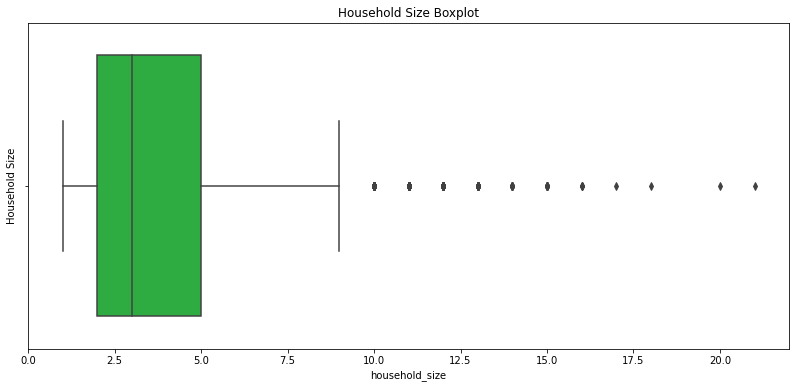

In [23]:
plt.figure(figsize=(30,6))
plt.subplot(1,2,1)
fig = sns.boxplot(x='household_size', data=train_dataframe, orient='v', color='#19C133')
fig.set_title("Household Size Boxplot")
fig.set_ylabel("Household Size")

## Analysis and Distributions <a name="analysis-dist"> </a>

In this step, we will investigate a little related to distributions and correlation matrices so that we have a notion of which columns have the greatest dependence on each other, in addition to deepening the knowledge of the data, understanding the ranges, bottlenecks and similar factors in the set. of data.

In [24]:
corr_matrix = train_dataframe.corr()
corr_matrix

,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent
year,1.000000,0.112318,0.214621,-0.066505,-0.052264,-0.019330,0.000317
bank_account,0.112318,1.000000,0.087288,0.209669,-0.028326,0.019429,0.117234
location_type,0.214621,0.087288,1.000000,-0.085238,-0.257284,-0.047373,0.012924
cellphone_access,-0.066505,0.209669,-0.085238,1.000000,0.091360,-0.103611,0.102370
household_size,-0.052264,-0.028326,-0.257284,0.091360,1.000000,-0.129729,0.014576
age_of_respondent,-0.019330,0.019429,-0.047373,-0.103611,-0.129729,1.000000,0.012745
gender_of_respondent,0.000317,0.117234,0.012924,0.102370,0.014576,0.012745,1.000000


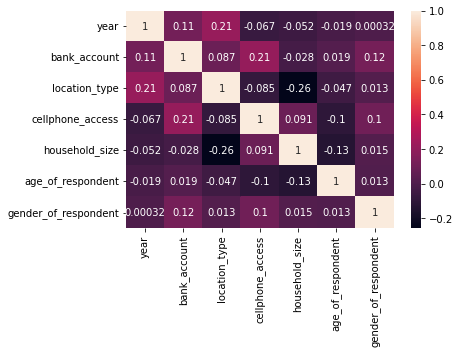

In [25]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

## Other Analysis <a name="other-analysis"> </a>
Among the analyses, several questions arise during the research, such as:

- What will be the age group with the lowest adhesion to the bank?
- Could it be that, as the Pennsylvania Higher Education Assistance Agency said, does the study directly affect people's earnings?
- Does the older age group have more illiterates, therefore, less adherence to cell phones and, later, less adherence to banks?

And among other questions that can be answered through the data, as we will briefly show below. However, we do not deviate from the focus, which is to know whether a person has a bank account or not, so it is important to focus on the study of the `bank_access` column.

Finally, statistical indicators can be performed together in this analysis, including curve analysis, such as kurtosis and skewness, for example.

In [37]:
DescribeResult = stats.describe(train_dataframe['age_of_respondent'])
print('Kurtosis: {}\nSkewness: {}\n(for age_of_respondent)'.format(DescribeResult[5], DescribeResult[4]))
print('\nKurtosis > 0 represents taper and Skewness > 0 represents a greater distribution on the right.')

Kurtosis: 0.09986209678376268
Skewness: 0.8416328173885442
(for age_of_respondent)

Kurtosis > 0 represents taper and Skewness > 0 represents a greater distribution on the right.


# Model <a name="model"></a>

In [42]:
categorical_cols.remove('uniqueid')
train_dataframe = pd.get_dummies(data = train_dataframe, columns = categorical_cols)
train_dataframe

In [43]:
X=train_dataframe.drop(['uniqueid', 'bank_account'], axis=1)

In [44]:
Y=train_dataframe['bank_account']

# Evaluation
 A métrica de avaliação para este desafio é o erro médio absoluto, onde 1 indica que o indivíduo possui uma conta bancária e 0 indica que não.

# Conclusion <a name="conclusion"></a>

# References <a name="references"></a>

- Financial Inclusion in Africa. **Zindi**. 2021. Avaliable in: \<https://zindi.africa/competitions/financial-inclusion-in-africa >. Acessed in: Oct 8th, 2021;
- The More You Learn, the More You Earn. **Pennsylvania Higher Education Assistance Agency**. 2021. Avaliable in: \<http://www.educationplanner.org/students/career-planning/explore-salary-pay/more-learn-more-earn.shtml >. Acessed in: Oct 12th, 2021.
- World Development Indicators. **The World Bank Group**. Dec 31th, 2020. Available in: \<https://datatopics.worldbank.org/world-development-indicators/ >. Acessed in: Oct 8th, 2021;